In [ ]:
# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import asc, count, col, mean
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder.appName("MobileHealthSegmentation").getOrCreate()

# Load the dataset
df = spark.read.csv("/content/drive/MyDrive/Datasets/mobile_health.csv", header=True, inferSchema=True)
df.show(3)

+------+-------+------------------+-------------------+-------------------+-------------------+-------+-------+--------------------+--------+-------+--------+--------+--------+
|   alx|    aly|               alz|                glx|                gly|                glz|    arx|    ary|                 arz|     grx|    gry|     grz|Activity| subject|
+------+-------+------------------+-------------------+-------------------+-------------------+-------+-------+--------------------+--------+-------+--------+--------+--------+
|2.1849|-9.6967|0.6307699999999999|             0.1039|-0.8405299999999999|           -0.68762|-8.6499|-4.5781| 0.18775999999999998|-0.44902|-1.0103|0.034483|       0|subject1|
|2.3876| -9.508|           0.68389|0.08534299999999999|           -0.83865|-0.6836899999999999|-8.6275|-4.3198|0.023594999999999998|-0.44902|-1.0103|0.034483|       0|subject1|
|2.4086|-9.5674|           0.68113|0.08534299999999999|           -0.83865|-0.6836899999999999|-8.5055|-4.2772| 0.2

# **EDA**

In [ ]:
df.printSchema()

root
 |-- alx: double (nullable = true)
 |-- aly: double (nullable = true)
 |-- alz: double (nullable = true)
 |-- glx: double (nullable = true)
 |-- gly: double (nullable = true)
 |-- glz: double (nullable = true)
 |-- arx: double (nullable = true)
 |-- ary: double (nullable = true)
 |-- arz: double (nullable = true)
 |-- grx: double (nullable = true)
 |-- gry: double (nullable = true)
 |-- grz: double (nullable = true)
 |-- Activity: integer (nullable = true)
 |-- subject: string (nullable = true)



In [ ]:
# Computes summary statistics
df.describe().show()

+-------+------------------+------------------+-------------------+--------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+--------+
|summary|               alx|               aly|                alz|                 glx|                gly|                 glz|                arx|               ary|               arz|               grx|                gry|               grz|          Activity| subject|
+-------+------------------+------------------+-------------------+--------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+--------+
|  count|           1215745|           1215745|            1215745|             1215745|            1215745|             1215745|            1215745|           1215745|          

In [ ]:
# Count missing values per column
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()

+---+---+---+---+---+---+---+---+---+---+---+---+--------+-------+
|alx|aly|alz|glx|gly|glz|arx|ary|arz|grx|gry|grz|Activity|subject|
+---+---+---+---+---+---+---+---+---+---+---+---+--------+-------+
|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|       0|      0|
+---+---+---+---+---+---+---+---+---+---+---+---+--------+-------+



In [ ]:
df = df.dropDuplicates() # No duplicate values present
df.select('Subject').distinct().orderBy(asc("Subject")).show() # There are 10 Subjects

+---------+
|  Subject|
+---------+
| subject1|
|subject10|
| subject2|
| subject3|
| subject4|
| subject5|
| subject6|
| subject7|
| subject8|
| subject9|
+---------+



In [ ]:
activity_counts = df.groupBy("Activity").agg(count("*").alias("Count"))
activity_counts.orderBy(asc("Activity")).show()

+--------+------+
|Activity| Count|
+--------+------+
|       0|872550|
|       1| 30720|
|       2| 30720|
|       3| 30720|
|       4| 30720|
|       5| 30720|
|       6| 28315|
|       7| 29441|
|       8| 29337|
|       9| 30720|
|      10| 30720|
|      11| 30720|
|      12| 10342|
+--------+------+



In [ ]:
# Returns columns of dataframe
print(f"Features: {df.columns}")

# Counts the number of rows in dataframe
print(f"There are {df.count()} Rows and {len(df.columns)} Columns.")

Features: ['alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'arx', 'ary', 'arz', 'grx', 'gry', 'grz', 'Activity', 'subject']
There are 1215745 Rows and 14 Columns.


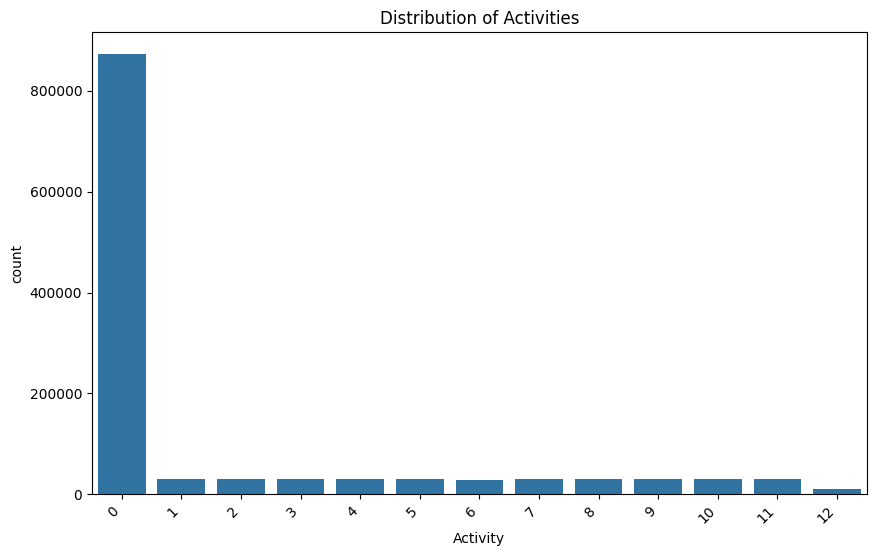

In [ ]:
df_pd = df.toPandas()
# Visualizing the Distribution of Activities
plt.figure(figsize=(10, 6))
sns.countplot(x='Activity', data=df_pd)
plt.title('Distribution of Activities')
plt.xticks(rotation=45, ha='right')
plt.show()

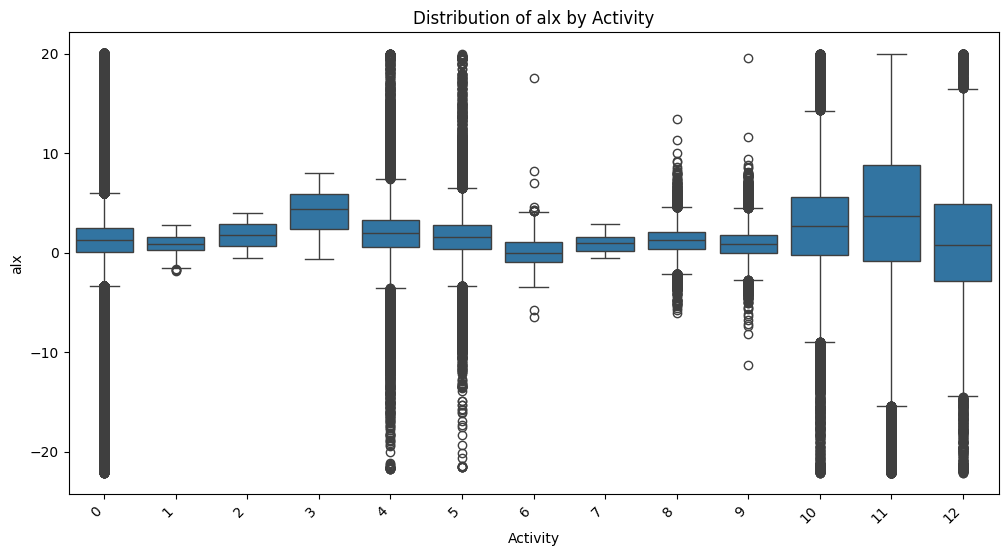

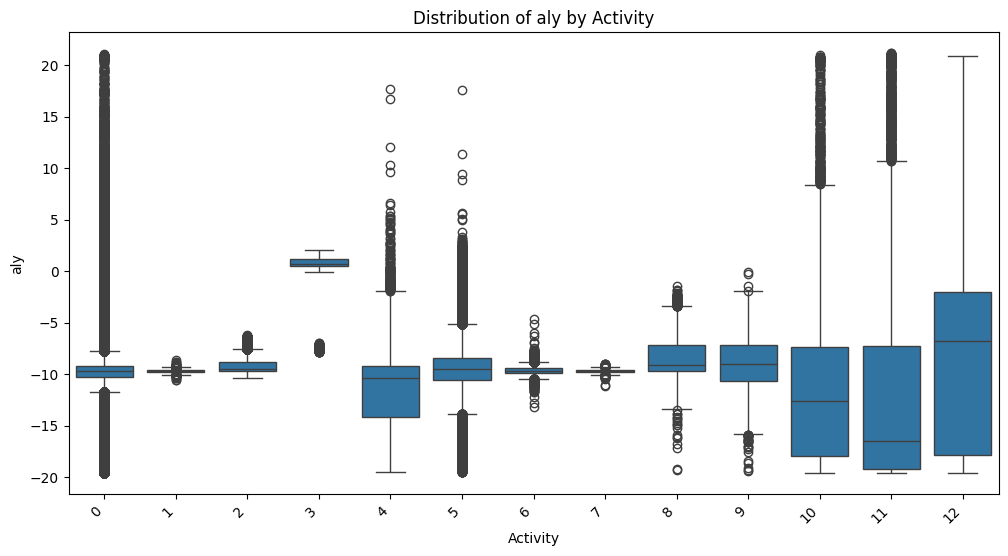

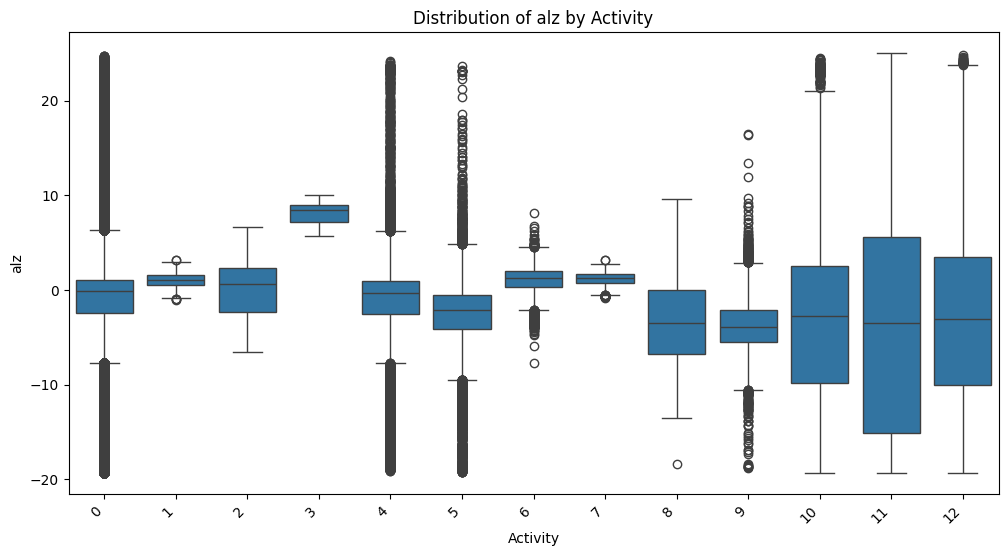

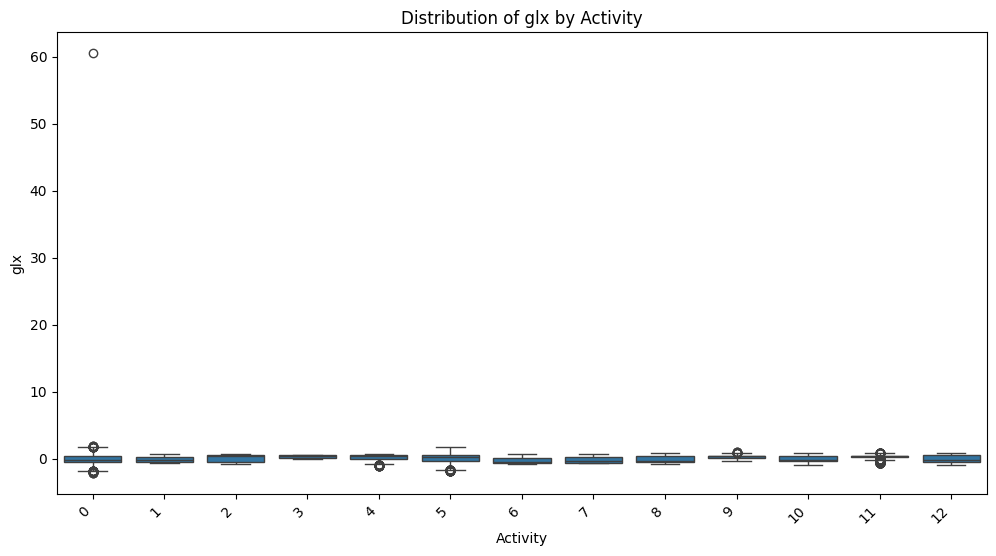

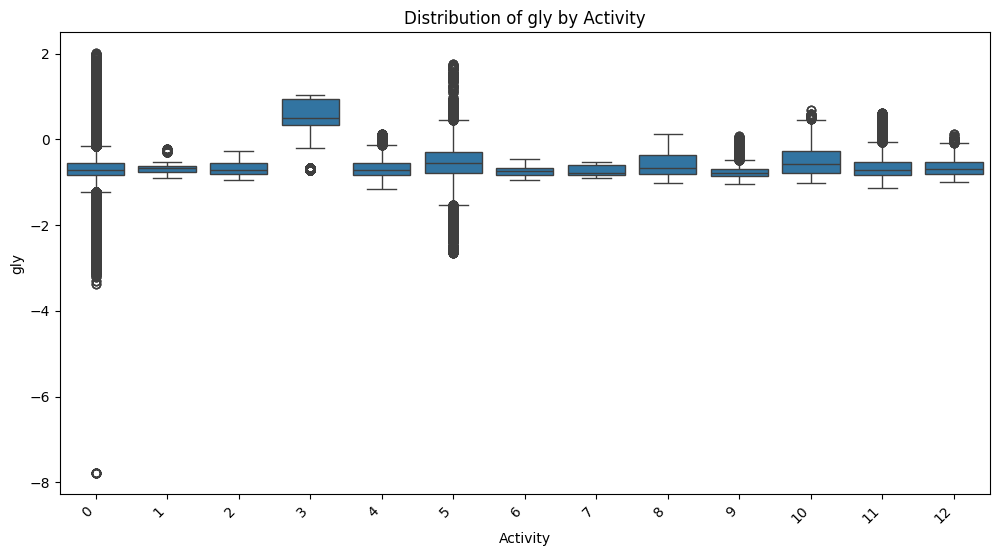

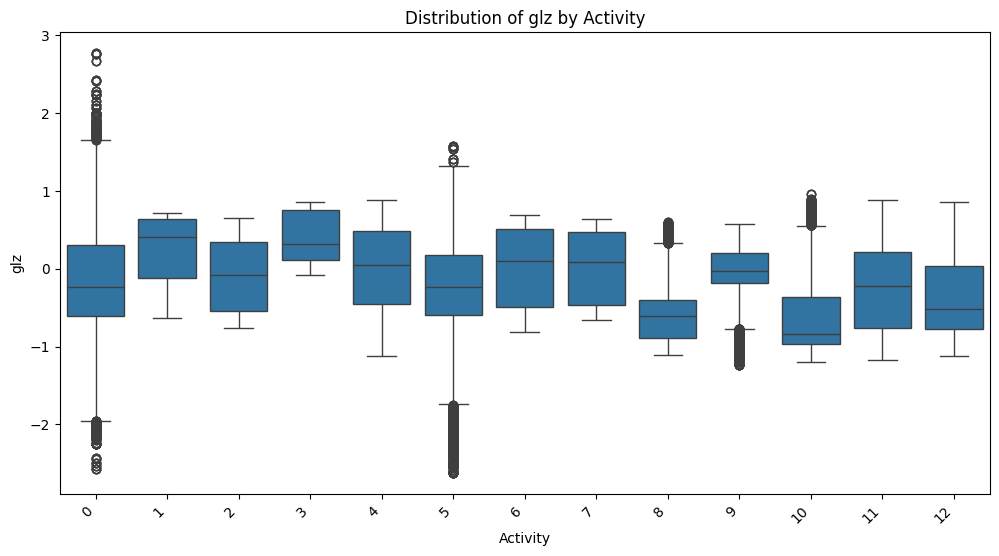

In [ ]:
# Box Plots for Sensor Readings by Activity:
for sensor in ['alx', 'aly', 'alz', 'glx', 'gly', 'glz']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Activity', y=sensor, data=df_pd)
    plt.title(f'Distribution of {sensor} by Activity')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [ ]:
def handle_outliers_iqr(df, column):
    """Handles outliers in a column using the IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with NaN
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = np.nan

    return df

# Apply outlier handling to sensor columns
for sensor in ['alx', 'aly', 'alz', 'glx', 'gly', 'glz']:
    df_pd = handle_outliers_iqr(df_pd, sensor)

# Impute missing values using linear interpolation
for sensor in ['alx', 'aly', 'alz', 'glx', 'gly', 'glz']:
    df_pd[sensor] = df_pd[sensor].interpolate(method='linear', limit_direction='both')

# 'df_pd' has outliers handled and missing values imputed.

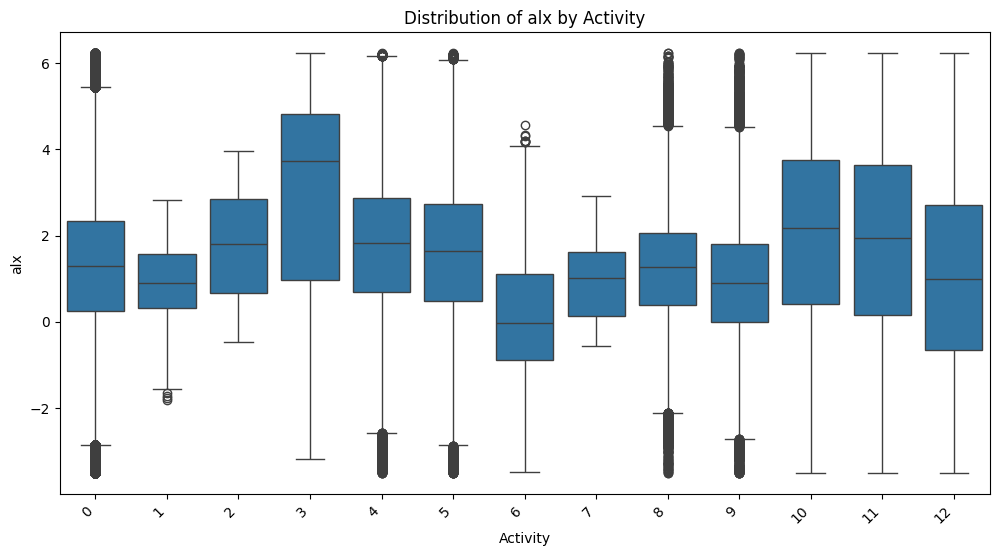

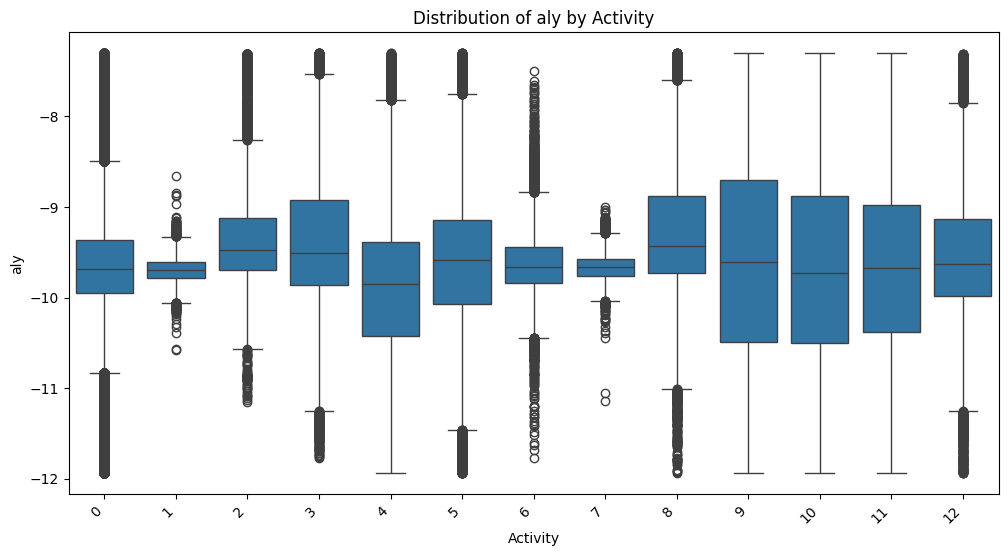

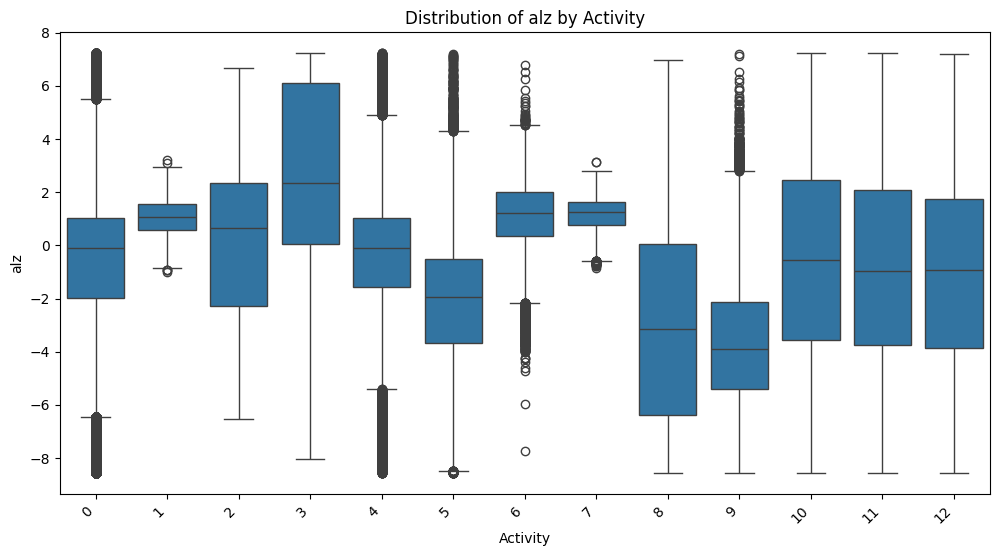

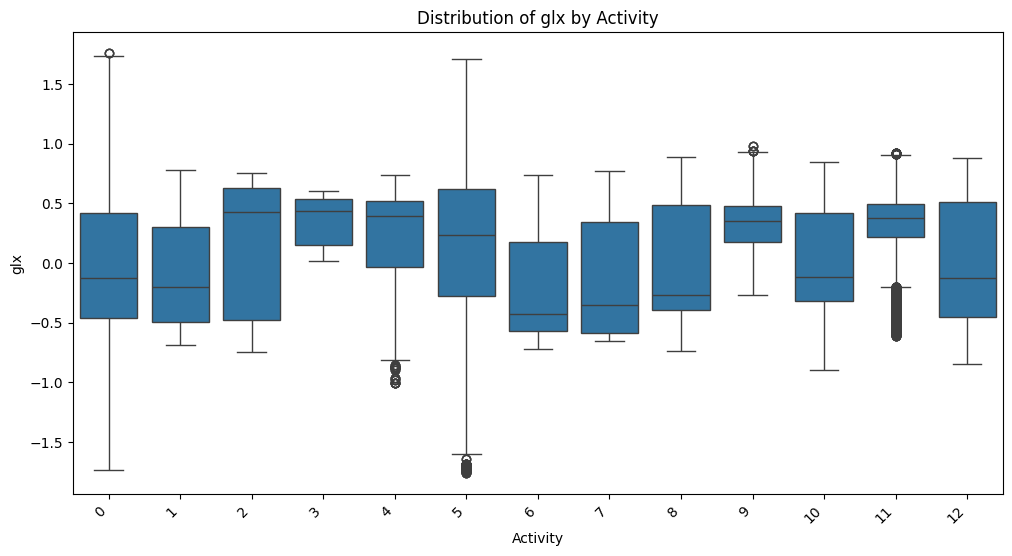

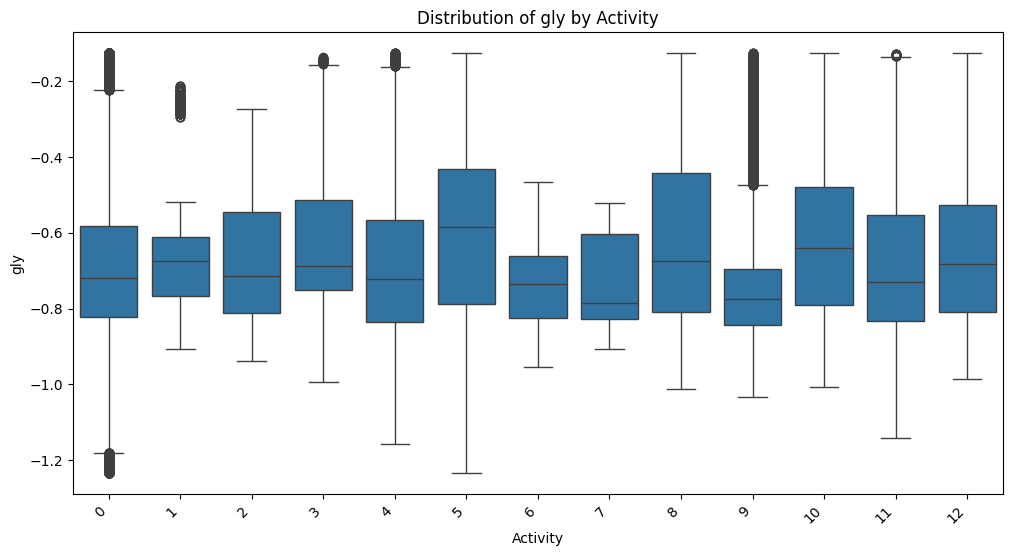

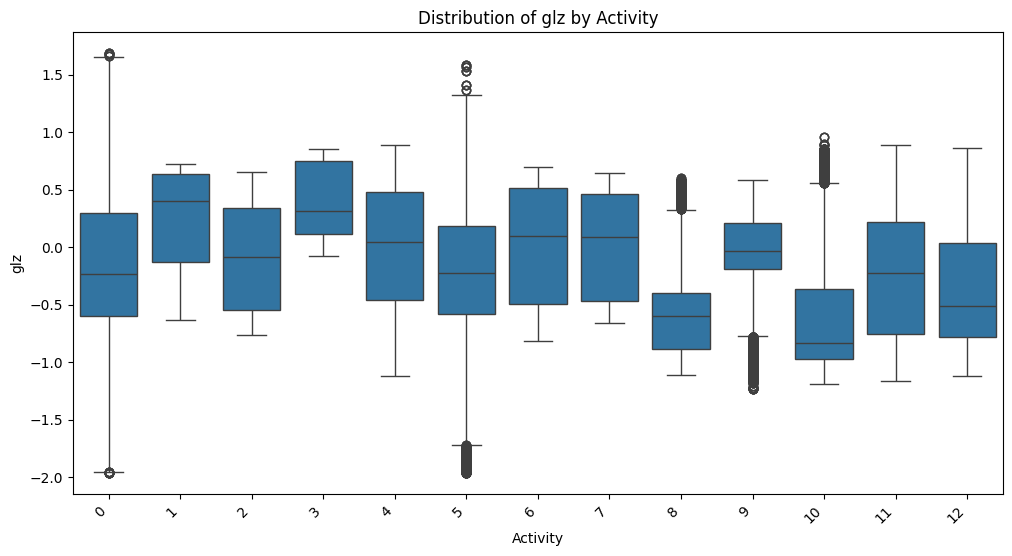

In [ ]:
# Box Plots for Sensor Readings by Activity:
for sensor in ['alx', 'aly', 'alz', 'glx', 'gly', 'glz']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Activity', y=sensor, data=df_pd)
    plt.title(f'Distribution of {sensor} by Activity')
    plt.xticks(rotation=45, ha='right')
    plt.show()

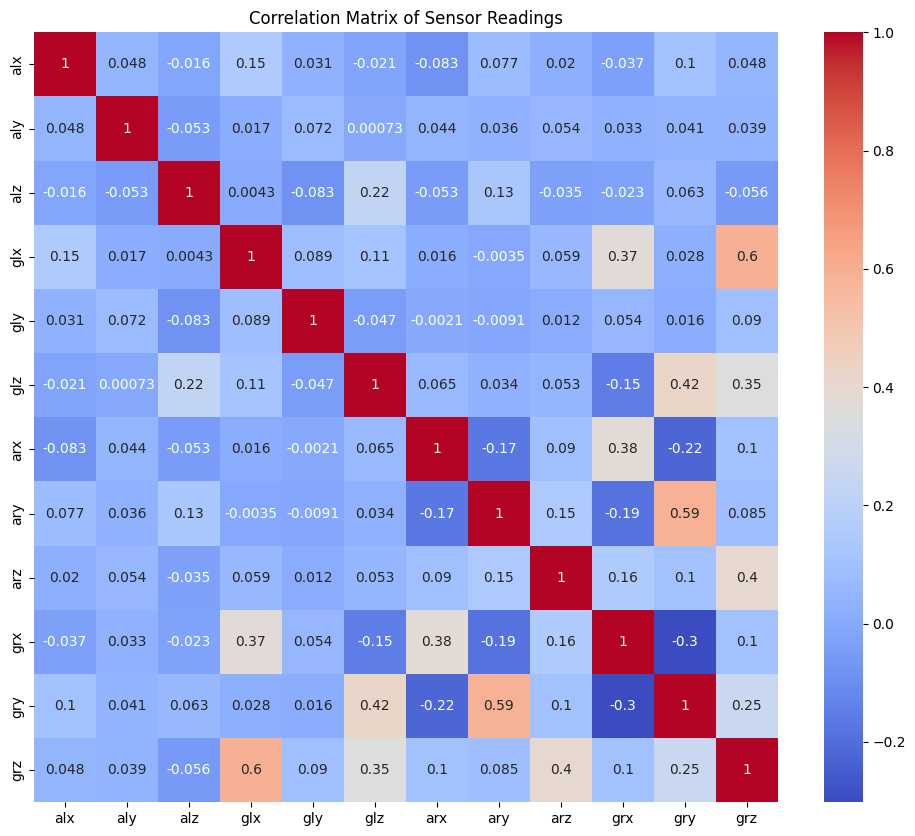

In [ ]:
# Select all columns except 'subject' and 'Activity'
features = [col for col in df_pd.columns if col not in ['subject', 'Activity']]

# Calculate the correlation matrix
corr_matrix = df_pd[features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Sensor Readings')
plt.show()

# **Data Modelling**

In [ ]:
# Select only sensor data for clustering
feature_cols = ["alx", "aly", "alz", "glx", "gly", "glz", "arx", "ary", "arz", "grx", "gry", "grz"]
df_selected = df.select(feature_cols)

# Show the modified dataframe
df_selected.show(3)

+------+-------+------------------+-------------------+-------------------+-------------------+-------+-------+--------------------+--------+-------+--------+
|   alx|    aly|               alz|                glx|                gly|                glz|    arx|    ary|                 arz|     grx|    gry|     grz|
+------+-------+------------------+-------------------+-------------------+-------------------+-------+-------+--------------------+--------+-------+--------+
|2.1849|-9.6967|0.6307699999999999|             0.1039|-0.8405299999999999|           -0.68762|-8.6499|-4.5781| 0.18775999999999998|-0.44902|-1.0103|0.034483|
|2.3876| -9.508|           0.68389|0.08534299999999999|           -0.83865|-0.6836899999999999|-8.6275|-4.3198|0.023594999999999998|-0.44902|-1.0103|0.034483|
|2.4086|-9.5674|           0.68113|0.08534299999999999|           -0.83865|-0.6836899999999999|-8.5055|-4.2772| 0.27571999999999997|-0.44902|-1.0103|0.034483|
+------+-------+------------------+-----------

In [ ]:
# Select only sensor data (for pure clustering)
feature_cols_only_sensors = ["alx", "aly", "alz", "glx", "gly", "glz", "arx", "ary", "arz", "grx", "gry", "grz"]
df_sensors = df.select(feature_cols_only_sensors)

# Select sensor data + Activity (for comparison)
feature_cols_with_activity = feature_cols_only_sensors + ["Activity"]
df_with_activity = df.select(feature_cols_with_activity)

# Show both versions
print("Sensor Data Only:")
df_sensors.show(3)

print("Sensor Data + Activity:")
df_with_activity.show(3)

Sensor Data Only:
+------+-------+------------------+-------------------+-------------------+-------------------+-------+-------+--------------------+--------+-------+--------+
|   alx|    aly|               alz|                glx|                gly|                glz|    arx|    ary|                 arz|     grx|    gry|     grz|
+------+-------+------------------+-------------------+-------------------+-------------------+-------+-------+--------------------+--------+-------+--------+
|2.1849|-9.6967|0.6307699999999999|             0.1039|-0.8405299999999999|           -0.68762|-8.6499|-4.5781| 0.18775999999999998|-0.44902|-1.0103|0.034483|
|2.3876| -9.508|           0.68389|0.08534299999999999|           -0.83865|-0.6836899999999999|-8.6275|-4.3198|0.023594999999999998|-0.44902|-1.0103|0.034483|
|2.4086|-9.5674|           0.68113|0.08534299999999999|           -0.83865|-0.6836899999999999|-8.5055|-4.2772| 0.27571999999999997|-0.44902|-1.0103|0.034483|
+------+-------+------------

In [ ]:
# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols_only_sensors, outputCol="features")
df_sensors_vector = assembler.transform(df_sensors)
df_with_activity_vector = assembler.transform(df_with_activity)

# Apply Min-Max Scaling
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_sensors_vector)
df_sensors_scaled = scaler_model.transform(df_sensors_vector)
df_with_activity_scaled = scaler_model.transform(df_with_activity_vector)

# Show scaled data
df_sensors_scaled.select("scaled_features").show(3, truncate=False)
df_with_activity_scaled.select("scaled_features", "Activity").show(3, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                                                            |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.5765616113744075,0.24331289847964688,0.45065715959268265,0.0359329145816901,0.7090325674407216,0.35930180847909876,0.3247152161042037,0.3496805383475452,0.4189804456571169,0.6767574707517069,0.4993856415657364,0.5007965512804015]   |
|[0.5813649289099526,0.2479401667484061,0.451853

In [ ]:
# Set number of clusters (initial guess, we will tune this later)
k = 3

# Train K-Means on sensor data only
kmeans_sensors = KMeans(featuresCol="scaled_features", k=k, seed=42)
model_sensors = kmeans_sensors.fit(df_sensors_scaled)
df_clusters_sensors = model_sensors.transform(df_sensors_scaled)

# Train K-Means on sensor data + Activity
kmeans_activity = KMeans(featuresCol="scaled_features", k=k, seed=42)
model_activity = kmeans_activity.fit(df_with_activity_scaled)
df_clusters_activity = model_activity.transform(df_with_activity_scaled)

# Show cluster assignments
print("Clusters without Activity:")
df_clusters_sensors.select("scaled_features", "prediction").show(5, truncate=False)

print("Clusters with Activity:")
df_clusters_activity.select("scaled_features", "prediction", "Activity").show(5, truncate=False)

Clusters without Activity:
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|scaled_features                                                                                                                                                                                                                            |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[0.5765616113744075,0.24331289847964688,0.45065715959268265,0.0359329145816901,0.7090325674407216,0.35930180847909876,0.3247152161042037,0.3496805383475452,0.4189804456571169,0.6767574707517069,0.4993856415657364,0.5007965512

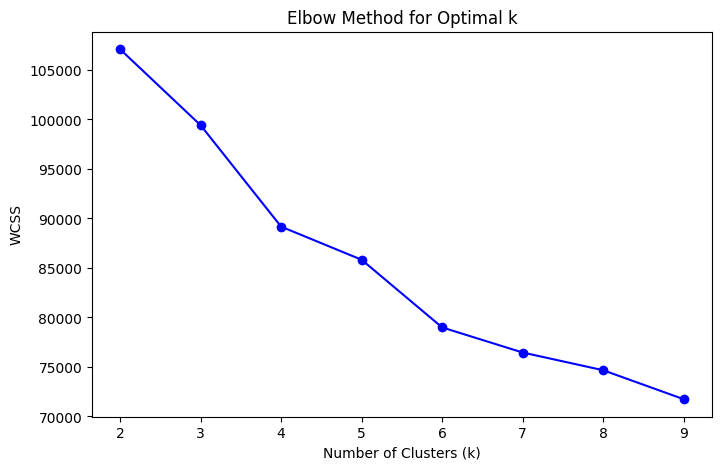

In [ ]:
wcss = []
k_values = list(range(2, 10))  # Testing k from 2 to 9

for k in k_values:
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(df_sensors_scaled)  # Using sensor data only
    wcss.append(model.summary.trainingCost)  # WCSS

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal k")
plt.show()

In [ ]:
# Clustering Without Activity
kmeans_opt = KMeans(featuresCol="scaled_features", k=5, seed=42)
model_opt = kmeans_opt.fit(df_sensors_scaled)
df_clustered_opt = model_opt.transform(df_sensors_scaled)
df_clustered_opt.select("scaled_features", "prediction").show(5)

+--------------------+----------+
|     scaled_features|prediction|
+--------------------+----------+
|[0.57656161137440...|         0|
|[0.58136492890995...|         0|
|[0.58186255924170...|         0|
|[0.57647867298578...|         0|
|[0.58206872037914...|         0|
+--------------------+----------+
only showing top 5 rows



In [ ]:
# Clustering With Activity
kmeans_opt_activity = KMeans(featuresCol="scaled_features", k=5, seed=42)
model_opt_activity = kmeans_opt_activity.fit(df_with_activity_scaled)
df_clustered_opt_activity = model_opt_activity.transform(df_with_activity_scaled)
df_clustered_opt_activity.select("scaled_features", "prediction", "Activity").show(5)

+--------------------+----------+--------+
|     scaled_features|prediction|Activity|
+--------------------+----------+--------+
|[0.57656161137440...|         0|       0|
|[0.58136492890995...|         0|       0|
|[0.58186255924170...|         0|       0|
|[0.57647867298578...|         0|       0|
|[0.58206872037914...|         0|       0|
+--------------------+----------+--------+
only showing top 5 rows



In [ ]:
df_clustered_opt.groupBy("prediction").count().orderBy("prediction").show()

+----------+------+
|prediction| count|
+----------+------+
|         0|468441|
|         1|391338|
|         2| 51771|
|         3| 38556|
|         4|265639|
+----------+------+



In [ ]:
df_clustered_opt_activity.groupBy("prediction").count().orderBy("prediction").show()

+----------+------+
|prediction| count|
+----------+------+
|         0|468441|
|         1|391338|
|         2| 51771|
|         3| 38556|
|         4|265639|
+----------+------+



In [ ]:
# Initialize ClusteringEvaluator with Silhouette Score using Euclidean Distance
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="prediction", metricName="silhouette", distanceMeasure="squaredEuclidean")

# Compute Silhouette Score
silhouette_score = evaluator.evaluate(df_clustered_opt)
print(f"Silhouette Score: {silhouette_score:.2f}")

Silhouette Score: 0.28


# **Model Deployment**

In [ ]:
model_opt.save("kmeans_model")

KMeansModel: uid=KMeans_e9863b24515f, k=5, distanceMeasure=euclidean, numFeatures=12

In [ ]:
df_clustered_opt.write.mode("overwrite").parquet("clustered_data.parquet")

In [ ]:
from pyspark.ml.clustering import KMeansModel

loaded_model = KMeansModel.load("kmeans_model")

KMeansModel: uid=KMeans_e9863b24515f, k=5, distanceMeasure=euclidean, numFeatures=12

In [ ]:
!pip install flask pyngrok pandas pyarrow

In [ ]:
from flask import Flask, render_template, jsonify
from pyngrok import ngrok
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
import os

app = Flask(__name__)

# Initialize Spark
spark = SparkSession.builder.appName("MobileHealthDeployment").getOrCreate()

# Load clustered data
clustered_df = spark.read.parquet("clustered_data.parquet")

# Compute cluster distribution
cluster_distribution = clustered_df.groupBy("prediction").count().toPandas().sort_values(by="prediction")

# Compute feature averages per cluster
feature_columns = [col for col in clustered_df.columns if col not in ["prediction", "features", "scaled_features"]]
cluster_summary = clustered_df.groupBy("prediction").agg(*[F.mean(col).alias(col) for col in feature_columns]).toPandas().sort_values(by="prediction")

@app.route('/')
def home():
    return render_template("index.html", clusters=cluster_distribution.to_dict(orient="records"), summary=cluster_summary.to_dict(orient="records"))

# Create templates folder if it doesn't exist
if not os.path.exists("templates"):
    os.makedirs("templates")

# Write HTML template
html_content = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Mobile Health Project Deployment</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet">
</head>
<body class="container mt-4">
    <h1 class="text-center">Mobile Health Sensor Segmentation</h1>
    <h2 class="mt-4">Cluster Distribution</h2>
    <table class="table table-bordered">
        <thead>
            <tr><th>Cluster</th><th>Count</th></tr>
        </thead>
        <tbody>
            {% for cluster in clusters %}
            <tr>
                <td>{{ cluster.prediction }}</td>
                <td>{{ cluster.count }}</td>
            </tr>
            {% endfor %}
        </tbody>
    </table>
    <h2 class="mt-4">Feature Averages per Cluster</h2>
    <table class="table table-bordered">
        <thead>
            <tr>
                <th>Cluster</th>
                {% for col in summary[0].keys() if col != 'prediction' %}
                <th>{{ col }}</th>
                {% endfor %}
            </tr>
        </thead>
        <tbody>
            {% for row in summary %}
            <tr>
                <td>{{ row.prediction }}</td>
                {% for col in row.keys() if col != 'prediction' %}
                <td>{{ row[col] | round(2) }}</td>
                {% endfor %}
            </tr>
            {% endfor %}
        </tbody>
    </table>
</body>
</html>
'''

with open("templates/index.html", "w") as f:
    f.write(html_content)

# Run the Flask app using ngrok
public_url = ngrok.connect(5000).public_url
print(f"Public URL: {public_url}")
app.run(port=5000)

Public URL: https://770f-34-16-166-136.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [24/Mar/2025 00:06:25] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Mar/2025 00:06:26] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
!ngrok authtoken 2uiCEWzFe4UYLLa29kE8cWzEpaA_6YXCEd5DdHByahjCRCgg5

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
